<a href="https://colab.research.google.com/github/John1495/RNA-3D/blob/main/TEST_GCNConv_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna
!pip install joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 37.1 MB/s eta 0:00:00


In [2]:
!pip install torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut


Evaluation Metrics:
RMSE: 1.001047
MAE: 0.148843
TM-Score: 0.999791
RMSD: 1.001047


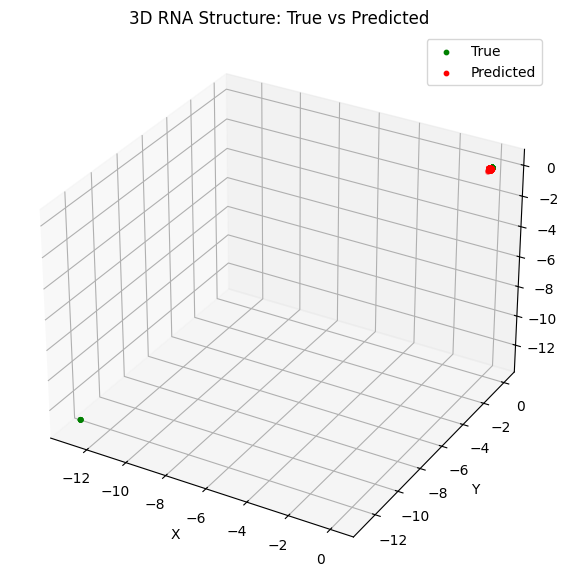

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load validation data
seq_df = pd.read_csv('/kaggle/validation_sequences.csv')
label_df = pd.read_csv('/kaggle/validation_labels.csv')

# Preprocess labels
label_df['resname'] = label_df['resname'].str.extract(r'([AUGC])')
label_df = label_df.dropna(subset=['resname'])
label_df['target_id'] = label_df['ID'].str.extract(r'(.+)_\d+')

# Merge with sequences
merged = pd.merge(label_df, seq_df[['target_id', 'sequence']], on='target_id', how='left')

# Filter complete structures
complete_ids = merged.groupby('target_id')['resid'].count()
valid_ids = complete_ids[complete_ids > 10].index
merged = merged[merged['target_id'].isin(valid_ids)]

# Fit scaler on validation coordinates
scaler = StandardScaler()
scaler.fit(merged[['x_1', 'y_1', 'z_1']])

# Residue encoding
residue_mapping = {'A': 0, 'U': 1, 'G': 2, 'C': 3}

def create_graph_from_group(df_group):
    df_group = df_group.sort_values('resid')
    node_features = torch.eye(4)[[residue_mapping[r] for r in df_group['resname']]]
    coords = df_group[['x_1', 'y_1', 'z_1']].values
    coords = scaler.transform(coords)
    pos = torch.tensor(coords, dtype=torch.float)
    y = pos
    n = len(df_group)
    edge_index = torch.tensor([[i, i+1] for i in range(n-1)] + [[i+1, i] for i in range(n-1)], dtype=torch.long).t().contiguous()
    return Data(x=node_features, edge_index=edge_index, pos=pos, y=y)

# Create validation graphs
val_graphs = []
for tid in valid_ids:
    g = create_graph_from_group(merged[merged['target_id'] == tid])
    val_graphs.append(g)
val_loader = DataLoader(val_graphs, batch_size=1)

# Define GCNConv model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Load saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=4, hidden_dim=32, output_dim=3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/GCNConv_Model.pth', map_location=device))
model.eval()

# Evaluate
predictions, true = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        pred_coords = model(batch)
        predictions.append(pred_coords.cpu().numpy())
        true.append(batch.y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
true = np.concatenate(true, axis=0)

# Metrics
rmse = np.sqrt(mean_squared_error(true, predictions))
mae = mean_absolute_error(true, predictions)

def calculate_tm_score(true, pred):
    d = np.linalg.norm(true - pred, axis=1)
    N = true.shape[0]
    return np.mean(np.exp(-d / (0.5 * N)))

def calculate_rmsd(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

tm_score = calculate_tm_score(true, predictions)
rmsd = calculate_rmsd(true, predictions)

print("\nEvaluation Metrics:")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"TM-Score: {tm_score:.6f}")
print(f"RMSD: {rmsd:.6f}")

# Plot 3D scatter
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(true[:, 0], true[:, 1], true[:, 2], c='g', label='True', s=10)
ax.scatter(predictions[:, 0], predictions[:, 1], predictions[:, 2], c='r', label='Predicted', s=10)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('3D RNA Structure: True vs Predicted')
ax.legend()
plt.show()


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Then save it to your drive
torch.save(model.state_dict(), '/content/drive/MyDrive/GCNConv_Model.pth')
joblib.dump(scaler, '/content/drive/MyDrive/GCNConc_Scaler.save')

print("Saved to Google Drive as 'GCNConv_Model.pth'")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved to Google Drive as 'GCNConv_Model.pth'
